# Clusters Analysis


Objective:
This project aims to perform a customer segmentation analysis using clustering techniques
(K-Means) to identify groups of clients with similar financial and behavioral characteristics.
The goal is to support debt recovery strategies by understanding profiles with different
probabilities of repayment and tailoring collection actions accordingly.

Dataset Description:
The dataset contains 1,000 customer records with demographic, financial, and behavioral features.
Key columns include:
- ID_Cliente: unique customer identifier
- Idade: customer's age
- Gênero and Estado: demographic information
- Produto: type of financial product (e.g., Credit Card, Personal Loan)
- Valor Devido (R$): outstanding debt value
- Dias em Atraso: number of overdue days
- Score Interno (0-1000): internal credit score
- Tentativas de Contato: number of contact attempts
- Último Contato: date of last contact
- Renda Estimada (R$): estimated monthly income

The analysis standardizes numeric variables, applies K-Means clustering to detect patterns,
and interprets each cluster’s profile in terms of financial capacity, risk, and recovery potential.
The insights guide prioritization of collection actions, communication channels, and campaign intensity.



In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## Data Exploration

In [94]:
filepath = Path("recuperacao_credito.csv")
df = pd.read_csv(filepath, sep=';')

In [95]:
type(df)

pandas.core.frame.DataFrame

In [96]:
df.head()

ID_Cliente  Idade     Gênero Estado             Produto  Valor Devido (R$)  \
0           1     56   Feminino     MG   Cartão de Crédito              17875   
1           2     69  Masculino     CE  Empréstimo Pessoal              16215   
2           3     46  Masculino     PR  Empréstimo Pessoal              22931   
3           4     32  Masculino     RS   Cartão de Crédito               4339   
4           5     60  Masculino     BA  Empréstimo Pessoal              18142   

   Dias em Atraso  Score Interno (0-1000)  Tentativas de Contato  \
0             128                     601                      4   
1              16                     576                      4   
2             145                     803                      0   
3              47                     864                      8   
4              21                     649                      0   

        Último Contato  Renda Estimada (R$)  
0  2025-01-16 00:00:00                 6713  
1  2025-03-05 00:00:00                14902  
2  2025-01-21 00:00:00                12329  
3  2025-01-09 00:00:00                11367  
4  2025-02-16 00:00:00                 6411

In [97]:
df[['Idade', 'Valor Devido (R$)', 'Dias em Atraso', 'Score Interno (0-1000)', 'Tentativas de Contato', 'Renda Estimada (R$)']].describe()

Idade  Valor Devido (R$)  Dias em Atraso  Score Interno (0-1000)  \
count  1000.00000        1000.000000     1000.000000             1000.000000   
mean     43.81900       15288.330000       93.630000              517.758000   
std      14.99103        8364.972037       51.197503              245.140685   
min      18.00000         567.000000        5.000000              100.000000   
25%      31.00000        7812.000000       47.000000              298.750000   
50%      44.00000       15031.500000       94.000000              521.000000   
75%      56.00000       22754.250000      137.250000              717.250000   
max      69.00000       29937.000000      180.000000              949.000000   

       Tentativas de Contato  Renda Estimada (R$)  
count            1000.000000          1000.000000  
mean                4.480000          7957.239000  
std                 2.900002          4157.400082  
min                 0.000000           843.000000  
25%                 2.000000          4451.750000  
50%                 4.000000          7997.000000  
75%                 7.000000         11443.000000  
max                 9.000000         14998.000000

In [98]:
# Count distinct
df.nunique()

ID_Cliente                1000
Idade                       52
Gênero                       3
Estado                      10
Produto                      2
Valor Devido (R$)          979
Dias em Atraso             176
Score Interno (0-1000)     579
Tentativas de Contato       10
Último Contato              60
Renda Estimada (R$)        967
dtype: int64

In [99]:
# Duplicates
df.duplicated().sum()

0

In [100]:
# Nuls
df.isna().sum().sort_values(ascending=False)

ID_Cliente                0
Idade                     0
Gênero                    0
Estado                    0
Produto                   0
Valor Devido (R$)         0
Dias em Atraso            0
Score Interno (0-1000)    0
Tentativas de Contato     0
Último Contato            0
Renda Estimada (R$)       0
dtype: int64

Auxiliary Columns:
To enhance the clustering analysis and improve interpretation, additional engineered features 
were created from the original dataset:

- Dias_desde_ultimo_contato: Number of days since the last recorded contact, indicating customer recency and engagement level.
- Valor_sobre_Renda: Ratio between the outstanding debt and estimated monthly income, used as a proxy for financial burden and repayment capacity.
- Valor_Log: Log-transformed debt value to reduce skewness and stabilize variance in clustering.
- Grupo_Atraso: Categorical variable grouping customers by overdue days (e.g., 0–30, 31–60, 61–90, 90+).
- Grupo_Renda: Income segmentation in multiples of the minimum wage (e.g 1 SM, 1–3 SM, 3–6 SM, 6–10 SM, 10+ SM).
- Contato_Recente_30d: Binary indicator (1/0) for customers contacted within the last 30 days.
- Tentativas_por_30d_Atraso: Number of contact attempts per 30 days of delay, representing contact intensity adjusted for delinquency duration.
- Grupo_Idade: customer age group (e.g., 18–25, 26–30, 31–40, 41–50, 51–60, 60+)
- Grupo_Score: internal credit score group (e.g., <250, 251-500, 501-750, >750)

These columns were included to capture behavioral, temporal, and proportional aspects of the customers, allowing for a more robust segmentation and a clearer understanding of each cluster’s risk and recovery potential.

In [101]:
df["divida_por_renda"] = (df["Valor Devido (R$)"] / df["Renda Estimada (R$)"]).round(2)


In [102]:
reference_day = pd.Timestamp("2025-03-09")  

df["Último Contato"] = pd.to_datetime(df["Último Contato"], errors="coerce")
df["Dias_desde_ultimo_contato"] = (reference_day - df["Último Contato"]).dt.days

In [103]:
df["Contato_Recente_30d"] = (df["Dias_desde_ultimo_contato"] <= 30).astype(int)

In [104]:
df["Grupo_Atraso"] = df["Dias em Atraso"].apply(
    lambda x: "<=90" if x <= 90 else ">90"
)

In [105]:
# Income segmentation in multiples of the minimum wage SM minimun salary in Brazil
salario_minimo = 1412  

# minimun salary by income
df["Qtd_Salarios_Minimos"] = df["Renda Estimada (R$)"] / salario_minimo

# group by amount of minimun salaries
df["Grupo_Renda"] = pd.cut(
    df["Qtd_Salarios_Minimos"],
    bins=[-np.inf, 1, 3, 6, 10, np.inf],        
    labels=["1 SM", "1-3 SM", "3-6 SM", "6-10 SM", "10+ SM"],  
    right=True                                  
)

In [106]:
df["Grupo_Score"] = pd.cut(
    df["Score Interno (0-1000)"],
    bins=[-np.inf, 250, 500, 750, np.inf],        
    labels=["i.0-250", "ii.251-500", "iii.501-750", "iv.750+"],  
    right=True                                  
)

In [107]:
df["Grupo_Idade"] = pd.cut(
    df["Idade"],
    bins=[-np.inf, 20, 30, 40, 50, 60, np.inf],        
    labels=["18-20", "21-30", "31-40", "41-50", "51-60", "60+"],  
    right=True                                  
)

In [108]:
df.head()

ID_Cliente  Idade     Gênero Estado             Produto  Valor Devido (R$)  \
0           1     56   Feminino     MG   Cartão de Crédito              17875   
1           2     69  Masculino     CE  Empréstimo Pessoal              16215   
2           3     46  Masculino     PR  Empréstimo Pessoal              22931   
3           4     32  Masculino     RS   Cartão de Crédito               4339   
4           5     60  Masculino     BA  Empréstimo Pessoal              18142   

   Dias em Atraso  Score Interno (0-1000)  Tentativas de Contato  \
0             128                     601                      4   
1              16                     576                      4   
2             145                     803                      0   
3              47                     864                      8   
4              21                     649                      0   

  Último Contato  Renda Estimada (R$)  divida_por_renda  \
0     2025-01-16                 6713              2.66   
1     2025-03-05                14902              1.09   
2     2025-01-21                12329              1.86   
3     2025-01-09                11367              0.38   
4     2025-02-16                 6411              2.83   

   Dias_desde_ultimo_contato  Contato_Recente_30d Grupo_Atraso  \
0                         52                    0          >90   
1                          4                    1         <=90   
2                         47                    0          >90   
3                         59                    0         <=90   
4                         21                    1         <=90   

   Qtd_Salarios_Minimos Grupo_Renda  Grupo_Score Grupo_Idade  
0              4.754249      3-6 SM  iii.501-750       51-60  
1             10.553824      10+ SM  iii.501-750         60+  
2              8.731586     6-10 SM      iv.750+       41-50  
3              8.050283     6-10 SM      iv.750+       31-40  
4              4.540368      3-6 SM  iii.501-750       51-60

In [109]:
resumo = df.groupby("Grupo_Atraso")["ID_Cliente"].agg(["count"]).sort_values("count", ascending=False)
display(resumo)

count
Grupo_Atraso       
>90             529
<=90            471

In [110]:
pd.crosstab(df["Grupo_Atraso"], df["Produto"])

Produto       Cartão de Crédito  Empréstimo Pessoal
Grupo_Atraso                                       
<=90                        207                 264
>90                         202                 327

# Dataset separation by type of product

In [111]:
df_cartao = df[df["Produto"] == "Cartão de Crédito"]

In [112]:
df_emprestimo = df[df["Produto"] == "Empréstimo Pessoal"]

## Variable Standardization
Required to bring all columns to the same scale, with mean ≈ 0 and standard deviation ≈ 1,
which will be used in the K-Means clustering algorithm.

In [113]:
#interesting columns
num_cols = [
    "Valor Devido (R$)",
    "Dias em Atraso",
    "Score Interno (0-1000)",
    "Tentativas de Contato",
    "Renda Estimada (R$)",
    "Dias_desde_ultimo_contato",  
    "Idade"
]

In [114]:
padronizador = StandardScaler()

In [115]:
#credit card
dados_padronizados_cartao = padronizador.fit_transform(df_cartao[num_cols])  
print(dados_padronizados_cartao)

[[ 0.27864748  0.68032856  0.36196899 ... -0.30794191  1.27947895
   0.833064  ]
 [-1.33870311 -0.90745621  1.41742897 ...  0.81335413  1.68388922
  -0.78429285]
 [ 1.06940001 -0.51541059 -1.59645104 ...  0.53989667  0.41288551
  -1.25602193]
 ...
 [-0.07598436 -0.22137637 -0.07947815 ... -0.12844781 -1.55139295
   1.10262347]
 [ 0.71823324  0.17066925  1.32913954 ...  0.58760115  1.33725185
  -0.58212324]
 [ 1.01371994 -0.14296725 -1.33960907 ... -1.52247851  0.06624814
   0.76567413]]


In [116]:
# Personal Loan
dados_padronizados_emprestimo = padronizador.fit_transform(df_emprestimo[num_cols])  
print(dados_padronizados_emprestimo)

[[ 0.13207365 -1.51840983  0.22080368 ...  1.67567411 -1.54989774
   1.66136715]
 [ 0.93634757  0.99722672  1.15890293 ...  1.05693466  0.86963364
   0.13631558]
 [ 0.36284135 -1.42090454  0.52248318 ... -0.36619014 -0.59333882
   1.06460784]
 ...
 [-1.18870317 -0.21183891 -0.07674321 ...  1.21997599 -1.71870226
   1.26352761]
 [ 0.4399635   0.60720555 -0.95285352 ... -0.19184653  0.86963364
   1.3298342 ]
 [-0.28826606  0.06117591  0.74564335 ...  1.62613648 -0.31199797
   1.19722102]]


## K-Means Algorithm
- Algorithm used for customer segmentation  
- 3 clusters (arbitrary choice): high chance, medium chance, and low chance of recovery

Credit card:

In [117]:
# clusters number = 3
k=3
#model creation
kmeans = KMeans(n_clusters=k)
#training with variable standardization 
kmeans.fit(dados_padronizados_cartao)


KMeans(n_clusters=3)

In [118]:
#labels
df_cartao['cluster']=kmeans.labels_

C:\Users\clauo\AppData\Local\Temp\ipykernel_50304\1194681834.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cartao['cluster']=kmeans.labels_


In [119]:
df_cartao.head()

ID_Cliente  Idade     Gênero Estado            Produto  Valor Devido (R$)  \
0           1     56   Feminino     MG  Cartão de Crédito              17875   
3           4     32  Masculino     RS  Cartão de Crédito               4339   
5           6     25  Masculino     CE  Cartão de Crédito              24493   
7           8     56  Masculino     SP  Cartão de Crédito              25590   
8           9     36  Masculino     DF  Cartão de Crédito              14019   

   Dias em Atraso  Score Interno (0-1000)  Tentativas de Contato  \
0             128                     601                      4   
3              47                     864                      8   
5              67                     113                      4   
7              40                     446                      8   
8              12                     409                      3   

  Último Contato  Renda Estimada (R$)  divida_por_renda  \
0     2025-01-16                 6713              2.66   
3     2025-01-09                11367              0.38   
5     2025-01-31                10232              2.39   
7     2025-01-27                 8885              2.88   
8     2025-03-07                13486              1.04   

   Dias_desde_ultimo_contato  Contato_Recente_30d Grupo_Atraso  \
0                         52                    0          >90   
3                         59                    0         <=90   
5                         37                    0         <=90   
7                         41                    0         <=90   
8                          2                    1         <=90   

   Qtd_Salarios_Minimos Grupo_Renda  Grupo_Score Grupo_Idade  cluster  
0              4.754249      3-6 SM  iii.501-750       51-60        0  
3              8.050283     6-10 SM      iv.750+       31-40        2  
5              7.246459     6-10 SM      i.0-250       21-30        1  
7              6.292493     6-10 SM   ii.251-500       51-60        0  
8              9.550992     6-10 SM   ii.251-500       31-40        1

In [120]:
resumo = df_cartao.groupby("cluster")["ID_Cliente"].agg(["count"]).sort_values("count", ascending=False)
display(resumo)

count
cluster       
2          142
1          141
0          126

Personal loan:

In [121]:
# clusters number = 3
k=3
#model creation
kmeans = KMeans(n_clusters=k)
#training with variable standardization 
kmeans.fit(dados_padronizados_emprestimo)

KMeans(n_clusters=3)

In [122]:
#atribuição de rotulos dos clusters aos clientes
df_emprestimo['cluster']=kmeans.labels_

C:\Users\clauo\AppData\Local\Temp\ipykernel_50304\3666484399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emprestimo['cluster']=kmeans.labels_


In [123]:
resumo = df_emprestimo.groupby("cluster")["ID_Cliente"].agg(["count"]).sort_values("count", ascending=False)
display(resumo)

count
cluster       
2          221
0          189
1          181

# Merge to save
For use in Power BI

In [124]:
df_total = pd.concat([df_cartao, df_emprestimo], ignore_index=True)

In [125]:
df_total.to_csv('segmentos.csv', index=False)

## Visualization 

In [126]:
colors = ["#B22222", "#E69F00", "#56B4E9"]  # escolha uma paleta consistente

### Credit Card clusters analysis

Delay range analysis

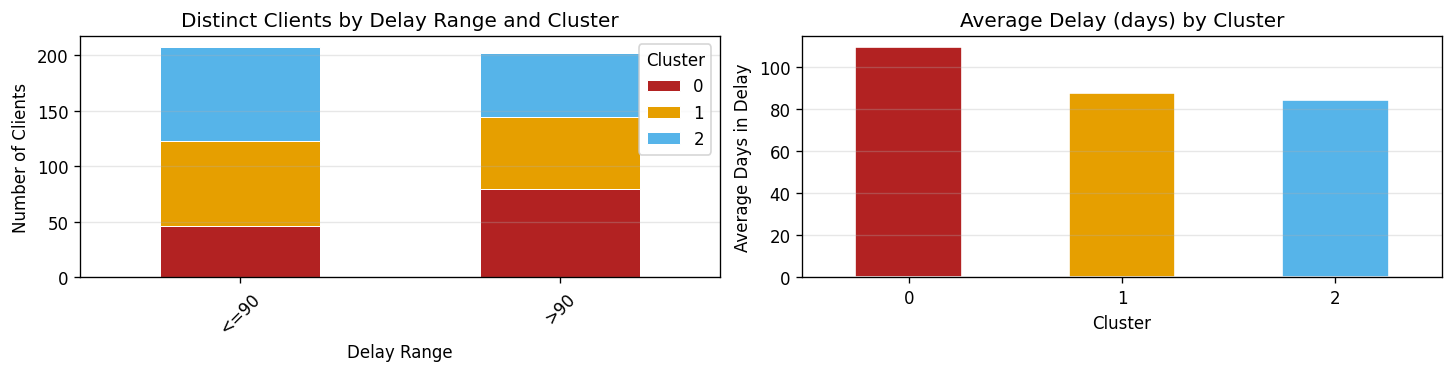

mean
cluster            
2         84.521127
1         87.709220
0        109.428571

In [143]:
#  1: Distinct Clients by Delay Range and Cluster 

tabela = (
    df_cartao.groupby(["Grupo_Atraso", "cluster"])["ID_Cliente"]
    .nunique()
    .unstack(fill_value=0)
    .sort_index()
)

# 2: Average Delay by Cluster 
avg_delay_by_cluster = (
    df_cartao.groupby("cluster")["Dias em Atraso"]
    .mean()
    .sort_index()
)

#  Unique image
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=120, constrained_layout=True)

# graphic 1
tabela.plot(
    kind="bar",
    stacked=True,
    color=colors,
    edgecolor="white",
    linewidth=0.6,
    ax=axes[0]
)

axes[0].set_title("Distinct Clients by Delay Range and Cluster")
axes[0].set_ylabel("Number of Clients")
axes[0].set_xlabel("Delay Range")
axes[0].set_xticklabels(tabela.index, rotation=45)
axes[0].grid(axis="y", alpha=0.3)
axes[0].legend(title="Cluster", loc="upper right")

# graphic 2
avg_delay_by_cluster.plot(
    kind="bar",
    color=colors,
    edgecolor="white",
    ax=axes[1]
)

axes[1].set_title("Average Delay (days) by Cluster")
axes[1].set_ylabel("Average Days in Delay")
axes[1].set_xlabel("Cluster")
axes[1].set_xticks(range(len(avg_delay_by_cluster)))
axes[1].set_xticklabels(avg_delay_by_cluster.index, rotation=0)
axes[1].grid(axis="y", alpha=0.3)

plt.show()

resumo = df_cartao.groupby("cluster")["Dias em Atraso"].agg(["mean"]).sort_values("cluster", ascending=False)
display(resumo)


Age


C:\Users\clauo\AppData\Local\Temp\ipykernel_50304\214406343.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cartao.groupby(["Grupo_Idade", "cluster"])["ID_Cliente"]


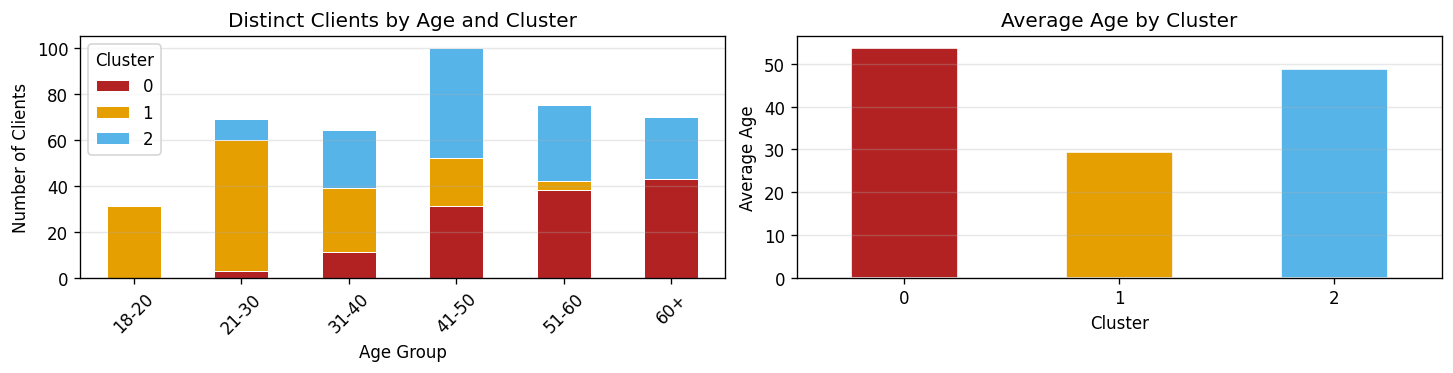

mean
cluster           
2        48.711268
1        29.411348
0        53.841270

In [144]:
#  1: Distinct Customer by Age and Cluster 


tabela = (
    df_cartao.groupby(["Grupo_Idade", "cluster"])["ID_Cliente"]
    .nunique()
    .unstack(fill_value=0)
    .sort_index()
)

# 2: Average Delay by Cluster 
avg_delay_by_cluster = (
    df_cartao.groupby("cluster")["Idade"]
    .mean()
    .sort_index()
)

#  Unique image
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=120, constrained_layout=True)

# graphic 1
tabela.plot(
    kind="bar",
    stacked=True,
    color=colors,
    edgecolor="white",
    linewidth=0.6,
    ax=axes[0]
)

axes[0].set_title("Distinct Clients by Age and Cluster")
axes[0].set_ylabel("Number of Clients")
axes[0].set_xlabel("Age Group")
axes[0].set_xticklabels(tabela.index, rotation=45)
axes[0].grid(axis="y", alpha=0.3)
axes[0].legend(title="Cluster", loc="upper left")

# graphic 2
avg_delay_by_cluster.plot(
    kind="bar",
    color=colors,
    edgecolor="white",
    ax=axes[1]
)

axes[1].set_title("Average Age by Cluster")
axes[1].set_ylabel("Average Age")
axes[1].set_xlabel("Cluster")
axes[1].set_xticks(range(len(avg_delay_by_cluster)))
axes[1].set_xticklabels(avg_delay_by_cluster.index, rotation=0)
axes[1].grid(axis="y", alpha=0.3)

plt.show()


resumo = df_cartao.groupby("cluster")["Idade"].agg(["mean"]).sort_values("cluster", ascending=False)
display(resumo)


Income

C:\Users\clauo\AppData\Local\Temp\ipykernel_50304\2423395511.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cartao.groupby(["Grupo_Renda", "cluster"])["ID_Cliente"]


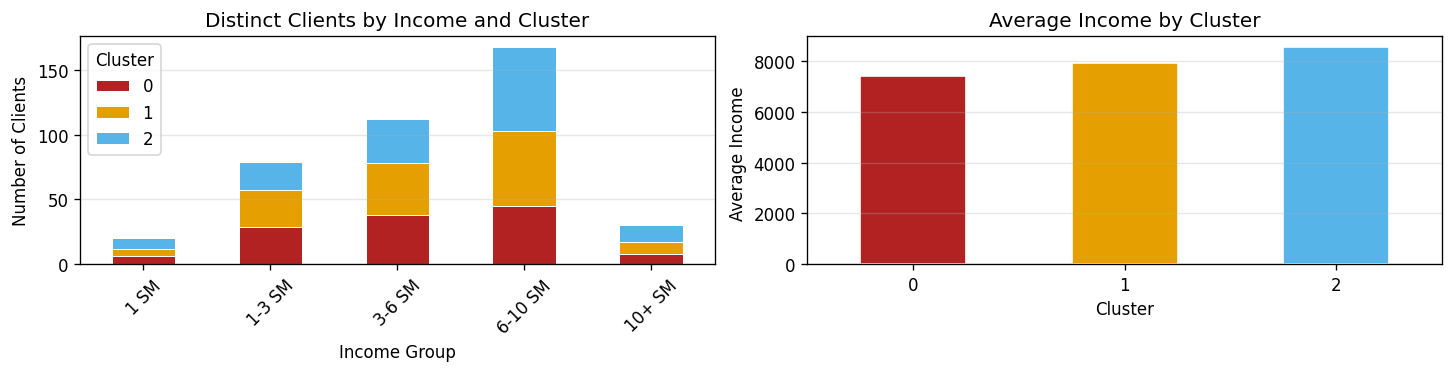

mean
cluster             
2        8565.021127
1        7939.992908
0        7401.587302

In [145]:
#  1: Distinct Customer by Income and Cluster 


tabela = (
    df_cartao.groupby(["Grupo_Renda", "cluster"])["ID_Cliente"]
    .nunique()
    .unstack(fill_value=0)
    .sort_index()
)

# 2: Average Delay by Cluster 
avg_delay_by_cluster = (
    df_cartao.groupby("cluster")["Renda Estimada (R$)"]
    .mean()
    .sort_index()
)

#  Unique image
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=120, constrained_layout=True)

# graphic 1
tabela.plot(
    kind="bar",
    stacked=True,
    color=colors,
    edgecolor="white",
    linewidth=0.6,
    ax=axes[0]
)

axes[0].set_title("Distinct Clients by Income and Cluster")
axes[0].set_ylabel("Number of Clients")
axes[0].set_xlabel("Income Group")
axes[0].set_xticklabels(tabela.index, rotation=45)
axes[0].grid(axis="y", alpha=0.3)
axes[0].legend(title="Cluster", loc="upper left")

# graphic 2
avg_delay_by_cluster.plot(
    kind="bar",
    color=colors,
    edgecolor="white",
    ax=axes[1]
)

axes[1].set_title("Average Income by Cluster")
axes[1].set_ylabel("Average Income ")
axes[1].set_xlabel("Cluster")
axes[1].set_xticks(range(len(avg_delay_by_cluster)))
axes[1].set_xticklabels(avg_delay_by_cluster.index, rotation=0)
axes[1].grid(axis="y", alpha=0.3)

plt.show()

resumo = df_cartao.groupby("cluster")["Renda Estimada (R$)"].agg(["mean"]).sort_values("cluster", ascending=False)
display(resumo)

Score

C:\Users\clauo\AppData\Local\Temp\ipykernel_50304\1561597079.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_cartao.groupby(["Grupo_Score", "cluster"])["ID_Cliente"]


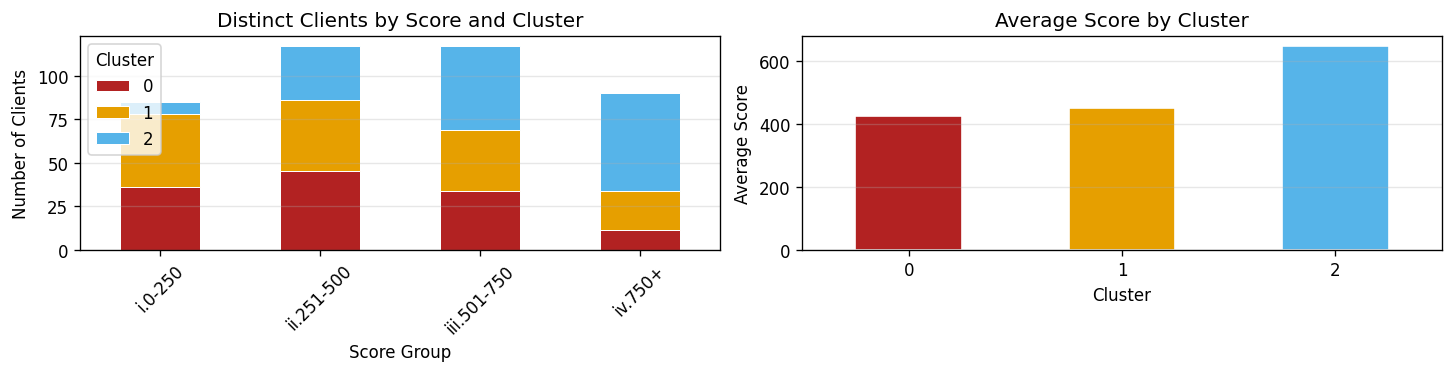

mean
cluster            
2        646.563380
1        451.517730
0        424.150794

In [146]:
#  1: Distinct Customer by Score and Cluster 


tabela = (
    df_cartao.groupby(["Grupo_Score", "cluster"])["ID_Cliente"]
    .nunique()
    .unstack(fill_value=0)
    .sort_index()
)

# 2: Average Delay by Cluster 
avg_delay_by_cluster = (
    df_cartao.groupby("cluster")["Score Interno (0-1000)"]
    .mean()
    .sort_index()
)

#  Unique image
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=120, constrained_layout=True)

# graphic 1
tabela.plot(
    kind="bar",
    stacked=True,
    color=colors,
    edgecolor="white",
    linewidth=0.6,
    ax=axes[0]
)

axes[0].set_title("Distinct Clients by Score and Cluster")
axes[0].set_ylabel("Number of Clients")
axes[0].set_xlabel("Score Group")
axes[0].set_xticklabels(tabela.index, rotation=45)
axes[0].grid(axis="y", alpha=0.3)
axes[0].legend(title="Cluster", loc="upper left")

# graphic 2
avg_delay_by_cluster.plot(
    kind="bar",
    color=colors,
    edgecolor="white",
    ax=axes[1]
)

axes[1].set_title("Average Score by Cluster")
axes[1].set_ylabel("Average Score")
axes[1].set_xlabel("Cluster")
axes[1].set_xticks(range(len(avg_delay_by_cluster)))
axes[1].set_xticklabels(avg_delay_by_cluster.index, rotation=0)
axes[1].grid(axis="y", alpha=0.3)

plt.show()

resumo = df_cartao.groupby("cluster")["Score Interno (0-1000)"].agg(["mean"]).sort_values("cluster", ascending=False)
display(resumo)

In [147]:
resumo = df_cartao.groupby("cluster")["Valor Devido (R$)"].agg(["mean"]).sort_values("cluster", ascending=False)
display(resumo)

mean
cluster              
2        11216.880282
1        19229.765957
0        16292.579365

In [148]:
resumo = df_cartao.groupby("cluster")["divida_por_renda"].agg(["mean"]).sort_values("cluster", ascending=False)
display(resumo)

mean
cluster          
2        1.995070
1        3.962695
0        3.593889

| Cluster | Main Characteristics                                                                                                                                                                                                                                          | Contact Frequency | Main Communication Channel                                                              |
| :-----: | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ | :---------------: | :-------------------------------------------------------------------------------------- |
|  **0**  | Younger customers (~42 yrs), moderate income (~R$ 7.5 K) and debt (~R$ 14 K). Delay ~94 days and medium score (509). Debt-to-income ratio high (≈2.7×). Already contacted moderately (~4 attempts). Moderate recovery potential with middle-class profile.    |     **Medium**    | **WhatsApp + SMS** — mobile channels with concise negotiation messages.                 |
|  **1**  | Older segment (~60 yrs), lower income (~R$ 6 K) and highest debt (~R$ 16 K). Delay the longest (~128 days) and lowest score (450). Most contacted (~5 attempts). Highest debt burden, low credit score and high aging make this group less likely to recover. |      **Low**      | **Email** — low-cost strategy; deprioritize short-term recovery actions.                |
|  **2**  | Mature customers (~47 yrs) with higher income (~R$ 10 K), lower debt (~R$ 14 K) and lowest average delay (~58 days). Highest score (572) and active engagement (4 attempts, last contact ~19 days). Financially strong, very high recovery probability.       |      **High**     | **WhatsApp + Phone** — direct, higher-intensity communication for immediate conversion. |


### Personal Loan  clusters analysis

Delay range analysis

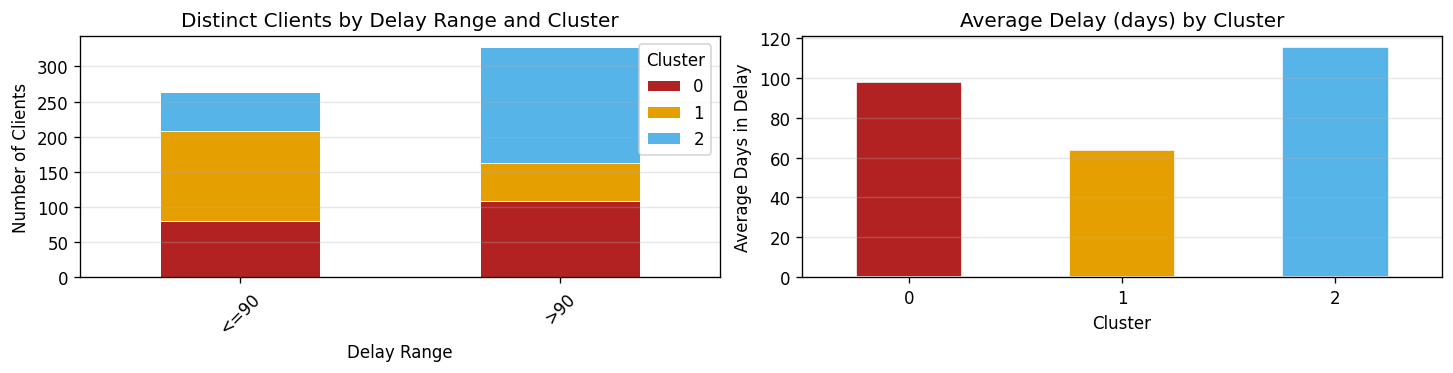

In [135]:
#  1: Distinct Clients by Delay Range and Cluster 

tabela = (
    df_emprestimo.groupby(["Grupo_Atraso", "cluster"])["ID_Cliente"]
    .nunique()
    .unstack(fill_value=0)
    .sort_index()
)

# 2: Average Delay by Cluster 
avg_delay_by_cluster = (
    df_emprestimo.groupby("cluster")["Dias em Atraso"]
    .mean()
    .sort_index()
)

#  Unique image
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=120, constrained_layout=True)

# graphic 1
tabela.plot(
    kind="bar",
    stacked=True,
    color=colors,
    edgecolor="white",
    linewidth=0.6,
    ax=axes[0]
)

axes[0].set_title("Distinct Clients by Delay Range and Cluster")
axes[0].set_ylabel("Number of Clients")
axes[0].set_xlabel("Delay Range")
axes[0].set_xticklabels(tabela.index, rotation=45)
axes[0].grid(axis="y", alpha=0.3)
axes[0].legend(title="Cluster", loc="upper right")

# graphic 2
avg_delay_by_cluster.plot(
    kind="bar",
    color=colors,
    edgecolor="white",
    ax=axes[1]
)

axes[1].set_title("Average Delay (days) by Cluster")
axes[1].set_ylabel("Average Days in Delay")
axes[1].set_xlabel("Cluster")
axes[1].set_xticks(range(len(avg_delay_by_cluster)))
axes[1].set_xticklabels(avg_delay_by_cluster.index, rotation=0)
axes[1].grid(axis="y", alpha=0.3)

plt.show()


Age

C:\Users\clauo\AppData\Local\Temp\ipykernel_50304\1071441742.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_emprestimo.groupby(["Grupo_Idade", "cluster"])["ID_Cliente"]


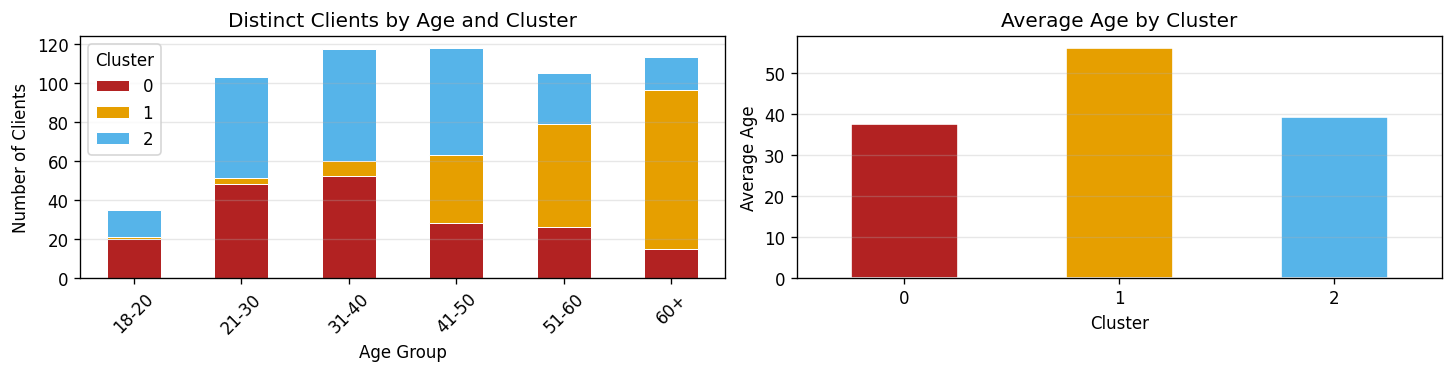

In [140]:
#  1: Distinct Customer by Age and Cluster 


tabela = (
    df_emprestimo.groupby(["Grupo_Idade", "cluster"])["ID_Cliente"]
    .nunique()
    .unstack(fill_value=0)
    .sort_index()
)

# 2: Average Delay by Cluster 
avg_delay_by_cluster = (
    df_emprestimo.groupby("cluster")["Idade"]
    .mean()
    .sort_index()
)

#  Unique image
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=120, constrained_layout=True)

# graphic 1
tabela.plot(
    kind="bar",
    stacked=True,
    color=colors,
    edgecolor="white",
    linewidth=0.6,
    ax=axes[0]
)

axes[0].set_title("Distinct Clients by Age and Cluster")
axes[0].set_ylabel("Number of Clients")
axes[0].set_xlabel("Age Group")
axes[0].set_xticklabels(tabela.index, rotation=45)
axes[0].grid(axis="y", alpha=0.3)
axes[0].legend(title="Cluster", loc="upper left")

# graphic 2
avg_delay_by_cluster.plot(
    kind="bar",
    color=colors,
    edgecolor="white",
    ax=axes[1]
)

axes[1].set_title("Average Age by Cluster")
axes[1].set_ylabel("Average Age")
axes[1].set_xlabel("Cluster")
axes[1].set_xticks(range(len(avg_delay_by_cluster)))
axes[1].set_xticklabels(avg_delay_by_cluster.index, rotation=0)
axes[1].grid(axis="y", alpha=0.3)

plt.show()


Income

C:\Users\clauo\AppData\Local\Temp\ipykernel_50304\764094075.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_emprestimo.groupby(["Grupo_Renda", "cluster"])["ID_Cliente"]


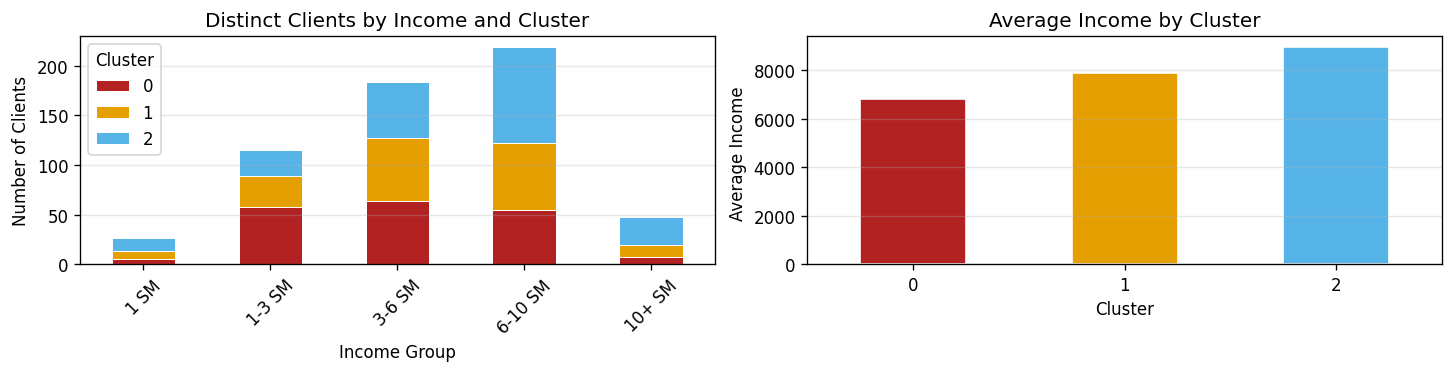

In [139]:
#  1: Distinct Customer by Income and Cluster 


tabela = (
    df_emprestimo.groupby(["Grupo_Renda", "cluster"])["ID_Cliente"]
    .nunique()
    .unstack(fill_value=0)
    .sort_index()
)

# 2: Average Delay by Cluster 
avg_delay_by_cluster = (
    df_emprestimo.groupby("cluster")["Renda Estimada (R$)"]
    .mean()
    .sort_index()
)

#  Unique image
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=120, constrained_layout=True)

# graphic 1
tabela.plot(
    kind="bar",
    stacked=True,
    color=colors,
    edgecolor="white",
    linewidth=0.6,
    ax=axes[0]
)

axes[0].set_title("Distinct Clients by Income and Cluster")
axes[0].set_ylabel("Number of Clients")
axes[0].set_xlabel("Income Group")
axes[0].set_xticklabels(tabela.index, rotation=45)
axes[0].grid(axis="y", alpha=0.3)
axes[0].legend(title="Cluster", loc="upper left")

# graphic 2
avg_delay_by_cluster.plot(
    kind="bar",
    color=colors,
    edgecolor="white",
    ax=axes[1]
)

axes[1].set_title("Average Income by Cluster")
axes[1].set_ylabel("Average Income ")
axes[1].set_xlabel("Cluster")
axes[1].set_xticks(range(len(avg_delay_by_cluster)))
axes[1].set_xticklabels(avg_delay_by_cluster.index, rotation=0)
axes[1].grid(axis="y", alpha=0.3)

plt.show()

Score

C:\Users\clauo\AppData\Local\Temp\ipykernel_50304\4014067758.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_emprestimo.groupby(["Grupo_Score", "cluster"])["ID_Cliente"]


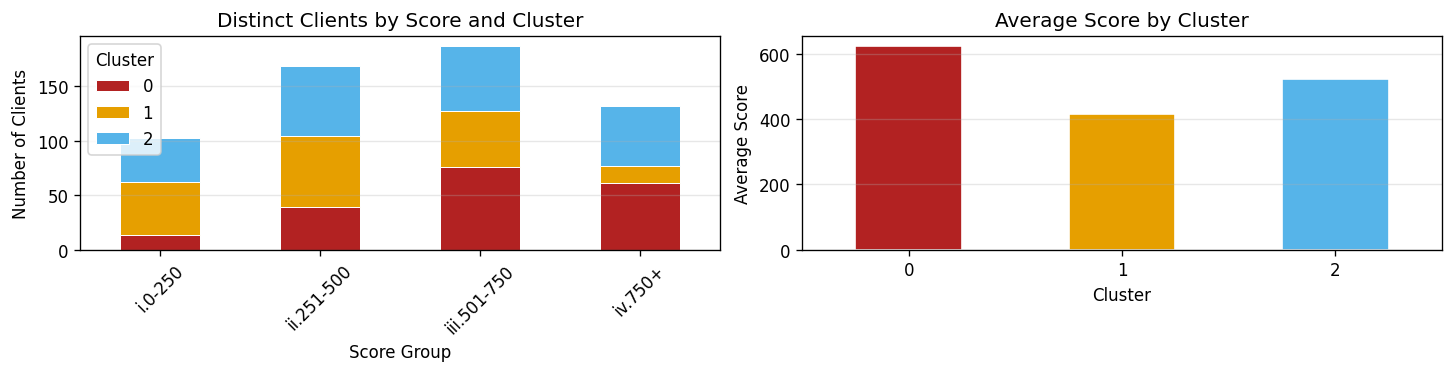

In [138]:
#  1: Distinct Customer by Score and Cluster 


tabela = (
    df_emprestimo.groupby(["Grupo_Score", "cluster"])["ID_Cliente"]
    .nunique()
    .unstack(fill_value=0)
    .sort_index()
)

# 2: Average Delay by Cluster 
avg_delay_by_cluster = (
    df_emprestimo.groupby("cluster")["Score Interno (0-1000)"]
    .mean()
    .sort_index()
)

#  Unique image
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3), dpi=120, constrained_layout=True)

# graphic 1
tabela.plot(
    kind="bar",
    stacked=True,
    color=colors,
    edgecolor="white",
    linewidth=0.6,
    ax=axes[0]
)

axes[0].set_title("Distinct Clients by Score and Cluster")
axes[0].set_ylabel("Number of Clients")
axes[0].set_xlabel("Score Group")
axes[0].set_xticklabels(tabela.index, rotation=45)
axes[0].grid(axis="y", alpha=0.3)
axes[0].legend(title="Cluster", loc="upper left")

# graphic 2
avg_delay_by_cluster.plot(
    kind="bar",
    color=colors,
    edgecolor="white",
    ax=axes[1]
)

axes[1].set_title("Average Score by Cluster")
axes[1].set_ylabel("Average Score")
axes[1].set_xlabel("Cluster")
axes[1].set_xticks(range(len(avg_delay_by_cluster)))
axes[1].set_xticklabels(avg_delay_by_cluster.index, rotation=0)
axes[1].grid(axis="y", alpha=0.3)

plt.show()

| Cluster | Main Characteristics                                                                                                                                                                                                                                                   | Contact Frequency | Main Communication Channel                                                                                                 |
| :-----: | :--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | :---------------: | :------------------------------------------------------------------------------------------------------------------------- |
|  **0**  | Mixed-age group (~45 yrs) with low income (~R$ 5 K) and small debt (~R$ 9 K). Delay ~94 days and moderate score (509). High debt-to-income ratio (~1.8×). Medium attempts (~4). Moderate to low recovery probability due to limited income capacity.                   |   **Medium–Low**  | **WhatsApp + SMS + Calls** — low-cost, mobile-friendly outreach; promote installment renegotiations to improve conversion. |
|  **1**  | Younger profile (<40 yrs mostly), income ~R$ 7 K, highest debt (~R$ 23 K) and lowest score (495). Shorter delay (~78 days). High debt burden (3.3×). Few attempts (~4). Low repayment capacity — deprioritize in short term.                                           |      **Low**      | **Email** — low-cost, low-intensity channel. Avoid frequent contact.                                                       |
|  **2**  | Older, high-income customers (~46 yrs, R$ 12 K/month), balanced debt (~R$ 12 K), highest score (564) and longest delay (~111 days). Lower debt-to-income ratio (1.0×). Most contacted (~5 attempts). Despite delay, high financial strength → best recovery potential. |      **High**     | **WhatsApp + Phone Calls** — higher intensity, direct channels suitable for mature and high-value clients.                 |


## Insights

For both products, Cluster 2 represents the best recovery potential — higher score, income, and engagement.

Cluster 1 in both products reflects high-risk, low-return customers — low priority, minimal investment.

Cluster 0 should receive controlled actions with moderate frequency and low-cost channels.